<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Sentiment Analysis VADER
</h1>
</div>



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Load required packages and the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np
from pprint import pprint

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy (for lemmatization)
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# TextBlob (for Sentiment Analysis)
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

# Vader (for Sentiment Analysis)
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

# Enable logging for gensim (optional)
import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Define a function to read in the preprocessed fulltext data
def read_preprocessed_fulltext(language):
    # Raise an error if an inadmissible language is chosen
    allowed_languages = ['de', 'en', 'fr', 'it']
    if language not in allowed_languages:
        raise ValueError("Invalid language. Expected one of: %s" % allowed_languages)
    
    # Set the appropriate working directory
    os.chdir('D:\\Dropbox\\MA_data')

    # Define the name of the file to load
    filename = "Preprocessed/Sentiment_Analysis/Fulltext/"+language+"_fulltext_senti.csv"

    # Read in the data
    tx_ft = pd.read_csv(filename, index_col = 0, dtype = {'tx': object})

    # Get the articles' index together with an enumeration to identify their position in the list of precleaned articles
    idx = tx_ft.index
    idx = pd.DataFrame(idx, columns = [language+'_idx'])

    # Extract the text data as a list of articles
    tx_ft = tx_ft.tx.to_list()

    # Return the preprocessed data
    return tx_ft, idx

In [4]:
# Read in the preprocessed fulltext data
fr_tx, fr_idx = read_preprocessed_fulltext('fr')

# Take a look at the size of the precleaned data
sys.getsizeof(fr_tx)

3849360

In [5]:
# Take a look at the preprocessed data
fr_tx[0]

" La Bourse de New York a terminé en hausse mercredi, sur les espoirs d'un prochain accord sur un nouveau plan d'aide économique américain qui a mené le Dow Jones brièvement au dessus de 2 en séance. Le Dow Jones Industrial Average a avancé de 1,20 à 27. 781,70 points. Le Nasdaq a gagné 0,74 à 11. 167,50 points et le S&P 500, a progressé de 1,05 à 3370,53 points. La Bourse de New York avait clôturé anxieusement en légère baisse mardi avant le débat présidentiel. Le Dow Jones Industrial Average, avait cédé 0,48 et le Nasdaq 0,29. Mercredi, la rencontre entre la cheffe des démocrates à la Chambre et le secrétaire américain au Trésor pour discuter d'une nouvelle aide économique, en panne depuis des mois, a suscité l'espoir d'un compromis raisonnable, selon les mots de Steven Mnuchin. Cet optimisme a donné un coup de fouet aux actions, qui s'est brusquement tempéré lorsque le chef des républicains au Sénat Mitch McConnell est sorti et a dit que les positions étaient encore très, très éloig

In [6]:
# Take a look at the dataframe containing the according index
fr_idx.tail(3)

,fr_idx
481159,2436480
481160,2436481
481161,2436482


In [7]:
# Retrieve the location of the article in the preprocessed data using the according article id
article_ids = [2436481, 2436482]
location = fr_idx[fr_idx.fr_idx.isin(article_ids)].index.tolist() #481160

# Access the preprocessed text from the articles with the article ids in [2436481, 2436482]
#list(fr_tx[i] for i in location)

# Look at the according location of the articles with the article ids in [2436481, 2436482]
location

[481160, 481161]

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2. Sentiment Assessment of the Articles
</h2>
</div>

In [8]:
# Define a function that evaluates the polarity of the articles and stores the result to a correctly indexed csv file
def eval_vader_polarity(tx, idx, name_output_file = 'fr_vader_polarity', batchsize = 100000, fuzzywuzzy = False):
    # Notes: 
    ## tx has to be a list containing the (precleaned) fulltext articles
    ## idx has to be a list containing the correctly ordered index
    ## fuzzywuzzy indicates whether the sentiment analysis algorithm should also look for similar words whenever a word is not detected properly to overcome issues with typos (computationally more expensive!) 

    # Initialize a Vader class, which uses the language specific SentimentIntensityAnalyzer we imported above to assess text polarity (sentiment from -1 to 1) and subjectivity
    sia = SentimentIntensityAnalyzer()

    # Set up a loop to go through all articles and evaluate their polarity with Vader
    i = 0
    i_last_batch = 0
    n_articles = len(tx)
    pol = []
    t = time.time()
    for article in tx:
        i = i + 1
        if fuzzywuzzy:
            pol.append(sia.polarity_scores_max(article)['compound'])
        else:
            pol.append(sia.polarity_scores(article)['compound'])
        if i % batchsize == 0:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            i_last_batch = i
            t = time.time()
        if i == n_articles:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            print("DONE! ;)")

    # Create a correctly indexed dataframe
    Vader_tx_polarity = pd.DataFrame(pol, index = idx, columns = ['Vader_polarity'])
    # Save the results to a csv file
    Vader_tx_polarity.to_csv("Sentiment/Vader/VADER-fr/"+name_output_file+".csv", index = True)
    # Return the results
    return Vader_tx_polarity

In [9]:
# Apply the previously defined function
Vader_tx_polarity = eval_vader_polarity(fr_tx, fr_idx.fr_idx.values.tolist(), 'fr_vader_polarity_original', 100000, False)

Processing time to evaluate polarity scores of the articles at positions 0 to 99999 : 34.04 minutes
Processing time to evaluate polarity scores of the articles at positions 100000 to 199999 : 32.05 minutes
Processing time to evaluate polarity scores of the articles at positions 200000 to 299999 : 29.55 minutes
Processing time to evaluate polarity scores of the articles at positions 300000 to 399999 : 42.83 minutes
Processing time to evaluate polarity scores of the articles at positions 400000 to 481161 : 26.19 minutes
DONE! ;)


In [10]:
# Take a look at the results
Vader_tx_polarity

,Vader_polarity
0,0.9785
1,-0.7772
2,0.7561
3,0.8078
4,-0.8205
...,...
2436478,0.4871
2436479,0.9305
2436480,-0.8833
2436481,0.6072


In [11]:
# Read the results back in
Vader_tx_polarity = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_original.csv", index_col = 0, dtype = {'Vader_polarity': float})

In [12]:
# Take a look at the read in results
Vader_tx_polarity

,Vader_polarity
0,0.9785
1,-0.7772
2,0.7561
3,0.8078
4,-0.8205
...,...
2436478,0.4871
2436479,0.9305
2436480,-0.8833
2436481,0.6072


In [13]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] > 0) / len(Vader_tx_polarity),2)
share_neg = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] < 0) / len(Vader_tx_polarity),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_polarity.describe(), 3)

The share of articles with a positive sentiment is 65.0 %
The share of articles with a negative sentiment is 34.0 %


,Vader_polarity
count,481162.000
mean,0.284
std,0.808
min,-1.000
25%,-0.700
50%,0.782
75%,0.966
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. Adjust the undesirable scoring function of the Vader sentiment package
</h2>
</div>

Inspecting the source code of the sentiment algorithm used by the Vader implementation reveals that, on a highly abstracted level, the output polarity score for a document is calculated as follows:

1. Initially assign a valence score of 0 to each token (Note: the valence score refers to a publicly assessed rating of a word's sentiment, ranging from -4 to 4, where -4 means extremely negative and 4 means extremely positive).

2. For each token, check whether it is contained in the underlying sentiment lexicon and, if yes, store the corresponding valence score.

3. Check for any intensifying, attenuating or negating words close to the token and, if required, adjust the valence score according to some specified rules.

4. Sum up the adjusted valence scores obtained for the tokens in a document. For document $j$ this sum is denoted $s_j$ in the following.

5. Obtain a document's polarity score (denoted as $p_j$) on a range from -1 to 1 by normalizing $s_j$ with the following scoring function: $$p_j = \frac{s_j}{\sqrt{s_j^2+15}}$$

However, since (especially for documents with a very clear sentiment) the absolute value of $s_j$ is inherently larger for longer documents, this algorithm delivers more extreme outcomes (in the sense of polarity scores close to -1 or 1) for longer articles. Furthermore, this approach delivers a clearly non-Gaussian distributed polarity score, which is an undesirable property when using it as the dependent variable in a subsequent regression analysis. We claim that this issue can be resolved by taking the average adjusted valence score of all tokens that exhibit a non-zero entry instead, and devide this value by 4 to transform the valence score (ranging from -4 to 4) into a polarity score, ranging from -1 to 1. Formally, this implies the usage of the alternative scoring function
$$p_j =  \frac{1}{4}*\frac{s_j}{l_j},$$
where $l_j$ refers to the number of tokens in document $j$ exhibiting a non-zero valence score. Thus, in order to obtain polarity scores that are calculated by this alternative approach, we propose the follwoing procedure:

1. Download the French Vader sentiment module from the according Github repository (link: https://github.com/thomas7lieues/vader_FR) and save the unzipped folder "vader_FR-master" (which contains the source files of the French Vader sentiment package) at some path (referred to as Path\to\vader_FR-master in the following). For me this path is C:\Users\Hallk\Documents\Programming\Additional_stuff\vader_FR-master.

2. Navigate to the folder "vaderSentiment_fr" within the folder "vader_FR-master" (located at the following path: Path\to\vader_FR-master\vaderSentiment_fr)

3. Replace the original "vaderSentiment.py" file located in this folder with the adjusted "vaderSentiment.py" file in the "vaderSentiment_fr" folder provided by this thesis (scoring function has been adjusted as described above). (Note: Alternatively to applying steps 1-3 one could also just copy the entire "vader_FR-master" folder provided by this thesis to Path\to\vader_FR-master and continue with step 4)

4. Open the commad window (i.e. cmd if you are using Windows as an operating system), activate your current working environment if desired (not necessary), and uninstall the current version of the French Vader sentiment package by entering the following command: pip uninstall vaderSentiment-fr

5. Keep the command window opened and install the locally stored, slightly adjusted version of the French Vader sentiment package by entering the following command: pip install -e Path\to\vader_FR-master. For me the command is: pip install -e C:\Users\Hallk\Documents\Programming\Additional_stuff\vader_FR-master

6. Restart Python and rerun the sentiment analysis. To do so, start by re-executing the first four cells of this Jupyter Notebook and then turn to the code provided below, which can be executed thereafter.

In [5]:
# Define a function that evaluates the polarity of the articles and stores the result to a correctly indexed csv file
def eval_vader_polarity(tx, idx, name_output_file = 'fr_vader_polarity', batchsize = 100000, fuzzywuzzy = False):
    # Notes: 
    ## tx has to be a list containing the (precleaned) fulltext articles
    ## idx has to be a list containing the correctly ordered index
    ## fuzzywuzzy indicates whether the sentiment analysis algorithm should also look for similar words whenever a word is not detected properly to overcome issues with typos (computationally more expensive!) 

    # Initialize a Vader class, which uses the language specific SentimentIntensityAnalyzer we imported above to assess text polarity (sentiment from -1 to 1) and subjectivity
    sia = SentimentIntensityAnalyzer()

    # Set up a loop to go through all articles and evaluate their polarity with Vader
    i = 0
    i_last_batch = 0
    n_articles = len(tx)
    pol = []
    t = time.time()
    for article in tx:
        i = i + 1
        if fuzzywuzzy:
            pol.append(sia.polarity_scores_max(article)['compound'])
        else:
            pol.append(sia.polarity_scores(article)['compound'])
        if i % batchsize == 0:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            i_last_batch = i
            t = time.time()
        if i == n_articles:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            print("DONE! ;)")

    # Create a correctly indexed dataframe
    Vader_tx_polarity = pd.DataFrame(pol, index = idx, columns = ['Vader_polarity'])
    # Save the results to a csv file
    Vader_tx_polarity.to_csv("Sentiment/Vader/VADER-fr/"+name_output_file+".csv", index = True)
    # Return the results
    return Vader_tx_polarity

In [6]:
# Apply the previously defined function
Vader_tx_polarity = eval_vader_polarity(fr_tx, fr_idx.fr_idx.values.tolist(), 'fr_vader_polarity_adjusted', 100000, False)

Processing time to evaluate polarity scores of the articles at positions 0 to 99999 : 34.29 minutes
Processing time to evaluate polarity scores of the articles at positions 100000 to 199999 : 34.79 minutes
Processing time to evaluate polarity scores of the articles at positions 200000 to 299999 : 31.79 minutes
Processing time to evaluate polarity scores of the articles at positions 300000 to 399999 : 43.54 minutes
Processing time to evaluate polarity scores of the articles at positions 400000 to 481161 : 27.09 minutes
DONE! ;)


In [7]:
# Take a look at the results
Vader_tx_polarity

,Vader_polarity
0,0.1582
1,-0.1196
2,0.0414
3,0.0780
4,-0.0869
...,...
2436478,0.0900
2436479,0.1367
2436480,-0.1520
2436481,0.0740


In [8]:
# Read the results back in
Vader_tx_polarity = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_adjusted.csv", index_col = 0, dtype = {'Vader_polarity': float})

In [9]:
# Take a look at the read in results
Vader_tx_polarity

,Vader_polarity
0,0.1582
1,-0.1196
2,0.0414
3,0.0780
4,-0.0869
...,...
2436478,0.0900
2436479,0.1367
2436480,-0.1520
2436481,0.0740


In [10]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] > 0) / len(Vader_tx_polarity),2)
share_neg = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] < 0) / len(Vader_tx_polarity),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_polarity.describe(), 3)

The share of articles with a positive sentiment is 65.0 %
The share of articles with a negative sentiment is 34.0 %


,Vader_polarity
count,481162.000
mean,0.052
std,0.172
min,-1.000
25%,-0.055
50%,0.068
75%,0.155
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
4. Extend the underlying sentiment lexicon with common covid-related words
</h2>
</div>

According to the adjusted Vader polarity scores estimated in the previous section most covid related newspaper articles appear to convey a slightly positive sentiment. However, this observation is against our expectations and we therefore try to figure out what might be driving these sentiment classification outcomes to be predominantly positive in the following. Since the Vader sentiment classification package relies on a lexicon based algorithm, inspecting the underlying sentiment lexicon seems a good starting point thereunto. As such, we check whether the following phrases, which - partly intuitively and partly according to the main LDA topic models - are strongly indicative for an article to be covid-related, are captured by the used sentiment lexicon:

- 'covid' ($\rightarrow$ 'covid' in French)
- 'corona' ($\rightarrow$ 'covid'/'coronavirus' in French)
- 'coronavirus' ($\rightarrow$ 'coronavirus' in French)
- 'virus' ($\rightarrow$ 'virus' in French)
- 'infection' ($\rightarrow$ 'infection'/'contagion'/'contamination' in French)
- 'infect' ($\rightarrow$ 'infecter'/'contaminer' in French)
- 'infected ($\rightarrow$ 'infecté'/'contaminé' in French)
- 'infectious' ($\rightarrow$ 'infectieux'/'miasmatique' in French)
- 'pandemic' ($\rightarrow$ 'pandémie' in French)
- 'epidemic' ($\rightarrow$ 'épidémie' in French)
- 'lockdown' ($\rightarrow$ 'lockdown'/'confinement' in French)
- 'crisis' ($\rightarrow$ 'crise' in French)
- 'quarantine' ($\rightarrow$ 'quarantaine' in French)
- 'hospitalisation' ($\rightarrow$ 'hospitalisation' in French)
- 'disease' ($\rightarrow$ 'maladie' in French)

Searching these words in the original French Vader lexicon reveals that most of them are not contained, meaning that most words in this list are not assigned an appropriate polarity score and therefore do not influence the overall polarity of the articles in which they appear. Since for all words in the above list it can reasonably be argued that they rather should convey a negative feeling, omitting them results in positively biased polarity scores for articles that contain them. Thus, we chase the following strategy to account for this issue: for each word listed above, we check whether the French equivalent or close synonyms of it are contained in the original French Vader lexicon in a first step. Thus, the following cases may occur:

 - Case 1 - The word itself as well as close synonyms of it are contained: in this case we check whether the valence score assigned to the focal word is negative and, if yes, leave the entry unchanged. Otherwise, we proceed as described in case 3.

 - Case 2 - The word itself is contained, but no close synonyms of it: in this case we check whether the valence score assigned to the focal word is negative and, if yes, leave the entry unchanged. Otherwise, we proceed as described in case 4.

 - Case 3 - A close synonym of the word is contained, but the word itself is not: in this case we check whether the valence score assigned to the synonym is negative and, if yes, assign the same valence score to the focal word. Otherwise, if the synonym's valence score is positive, we proceed as described in case 4.

 - Case 4 - Neither the word itself nor close synonyms of it are contained: in this case we start by checking whether the word's primary word (or a synonym's primary word) is contained in the lexicon and, if yes, assign the same valence score to the focal word. Otherwise, if the primary word is not contained, we continue by checking whether the German (or Italian) equivalent of the word is contained in the German Vader (or Italian sentix) sentiment lexicon. If yes, we assign the focal French word with the same valence score as observed in the German Vader lexicon (or with the valence score that corresponds to the polarity score observed in the Italian sentix lexicon (note: valence score = polarity score * 4)). If this approach also fails, we add the word and its synonyms with all grammatical cases or conjugations to the lexicon and assign a valence score of -4.

According to this strategy, we apply the following editings to the French Vader lexicon:

- 'covid' ($\rightarrow$ 'covid' in French): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'covid')
- 'corona' ($\rightarrow$ 'covid'/'coronavirus' in French): 'covid' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'covid') / 'coronavirus' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'coronavirus')
- 'coronavirus' ($\rightarrow$ 'coronavirus' in French): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'coronavirus')
- 'virus' ($\rightarrow$ 'virus' in French): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'virus')
- 'infection' ($\rightarrow$ 'infection'/'contagion'/'contamination' in French): 'contagion' already contained with a valence score of -2.0 $\rightarrow$ left unchanged / 'infection' not contained $\rightarrow$ assigned with a valence score of -2.0 since it is a close synonym of 'contagion' (added cases: 'infection', 'infections') / 'contamination' not contained $\rightarrow$ assigned with a valence score of -2.0 since it is a close synonym of 'contagion' (added cases: 'contamination', 'contaminations')
- 'infect' ($\rightarrow$ 'infecter'/'contaminer' in French): 'infecte' (i.e. the first conjugation of infecter) already contained with a valence score of -0.9 $\rightarrow$ left unchanged, but added missing conjugations (added cases: 'infectons', 'infectez', 'infectent') / 'contamine' (i.e. the first conjugation of contaminer) already contained with a valence score of -2.2 $\rightarrow$ left unchanged (Note: all conjugations are alreadey contained)
- 'infected ($\rightarrow$ 'infecté'/'contaminé' in French): 'infecté' already contained with a valence score of -2.2 $\rightarrow$ left unchanged / 'contaminé' already contained with a valence score of -2.0 $\rightarrow$ left unchanged
- 'infectious' ($\rightarrow$ 'infectieux'/'miasmatique' in French): neither 'infectieux' nor 'miasmatique' is contained $\rightarrow$ both assigned with a valence score of -2.0 since the primary word of 'infectieux' is 'infection' and 'infectieux' is a close synonym of 'miasmatique' (added cases: 'infectieux', 'miasmatique', 'miasmatique', 'miasmatique')
- 'pandemic' ($\rightarrow$ 'pandémie' in French): not contained $\rightarrow$ assigned with a valence score of -2.7 since this score is assigned to the German equivalent in the German Vader sentiment lexicon (added cases: 'pandémie')
- 'epidemic' ($\rightarrow$ 'épidémie' in French): not contained $\rightarrow$ assigned with a valence score of -2.7 since this score is assigned to the German equivalent in the German Vader sentiment lexicon (added cases: 'épidémie')
- 'lockdown' ($\rightarrow$ 'lockdown'/'confinement' in French): 'lockdown' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'lockdown', 'lockdowns') / 'confinement' not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'confinement', 'confinements')
- 'crisis' ($\rightarrow$ 'crise' in French): already contained with a valence score of -3.1 $\rightarrow$ left unchanged
- 'quarantine' ($\rightarrow$ 'quarantaine' in French): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'quarantaine', 'quarantaines')
- 'hospitalisation' ($\rightarrow$ 'hospitalisation' in French): not contained $\rightarrow$ assigned with a valence score of -4 (added cases: 'hospitalisation', 'hospitalisation')
- 'disease' ($\rightarrow$ 'maladie' in French): already contained with a valence score of -1.7 $\rightarrow$ left unchanged

After adjusting the sentiment lexicon as desired we use it to rerun the sentiment analysis. Thus, we have to apply the following steps:

1. Navigate to the folder "vaderSentiment_fr" within the folder "vader_FR-master" (located at Path\to\vader_FR-master\vaderSentiment_fr as described in the previous section) in which the previously created adjusted French Vader module is located. For me this means to navigate to C:\Users\Hallk\Documents\Programming\Additional_stuff\vader_FR-master\vaderSentiment_fr.

2. Replace the original lexicon file "fr_lexicon.txt" in your "vaderSentiment_fr" folder with the extended "fr_lexicon.txt" file located in the subfolder "sentiment_lexicon\extended" within the "vaderSentiment_fr" folder provided by this thesis.

3. Open the commad window (i.e. cmd if you are using Windows as an operating system), activate your current working environment if desired (not necessary), and uninstall the current version of the French Vader sentiment package by entering the following command: pip uninstall vaderSentiment-fr

4. Keep the command window opened and install the locally stored, slightly adjusted version of the French Vader sentiment package by entering the following command: pip install -e Path\to\vader_FR-master. For me the command is: pip install -e C:\Users\Hallk\Documents\Programming\Additional_stuff\vader_FR-master

5. Restart Python and rerun the sentiment analysis. To do so, start by re-executing the first four cells of this Jupyter Notebook and then turn to the code provided below, which can be executed thereafter.

In [5]:
# Define a function that evaluates the polarity of the articles and stores the result to a correctly indexed csv file
def eval_vader_polarity(tx, idx, name_output_file = 'fr_vader_polarity', batchsize = 100000, fuzzywuzzy = False):
    # Notes: 
    ## tx has to be a list containing the (precleaned) fulltext articles
    ## idx has to be a list containing the correctly ordered index
    ## fuzzywuzzy indicates whether the sentiment analysis algorithm should also look for similar words whenever a word is not detected properly to overcome issues with typos (computationally more expensive!) 

    # Initialize a Vader class, which uses the language specific SentimentIntensityAnalyzer we imported above to assess text polarity (sentiment from -1 to 1) and subjectivity
    sia = SentimentIntensityAnalyzer()

    # Set up a loop to go through all articles and evaluate their polarity with Vader
    i = 0
    i_last_batch = 0
    n_articles = len(tx)
    pol = []
    t = time.time()
    for article in tx:
        i = i + 1
        if fuzzywuzzy:
            pol.append(sia.polarity_scores_max(article)['compound'])
        else:
            pol.append(sia.polarity_scores(article)['compound'])
        if i % batchsize == 0:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            i_last_batch = i
            t = time.time()
        if i == n_articles:
            print("Processing time to evaluate polarity scores of the articles at positions", i_last_batch, "to", i-1, ":", str(round((time.time() - t)/60,2)), "minutes")
            print("DONE! ;)")

    # Create a correctly indexed dataframe
    Vader_tx_polarity = pd.DataFrame(pol, index = idx, columns = ['Vader_polarity'])
    # Save the results to a csv file
    Vader_tx_polarity.to_csv("Sentiment/Vader/VADER-fr/"+name_output_file+".csv", index = True)
    # Return the results
    return Vader_tx_polarity

In [6]:
# Apply the previously defined function
Vader_tx_polarity = eval_vader_polarity(fr_tx, fr_idx.fr_idx.values.tolist(), 'fr_vader_polarity_adjusted_2', 100000, False)

Processing time to evaluate polarity scores of the articles at positions 0 to 99999 : 34.7 minutes
Processing time to evaluate polarity scores of the articles at positions 100000 to 199999 : 33.95 minutes
Processing time to evaluate polarity scores of the articles at positions 200000 to 299999 : 30.74 minutes
Processing time to evaluate polarity scores of the articles at positions 300000 to 399999 : 44.44 minutes
Processing time to evaluate polarity scores of the articles at positions 400000 to 481161 : 28.64 minutes
DONE! ;)


In [7]:
# Take a look at the results
Vader_tx_polarity

,Vader_polarity
0,0.1582
1,-0.1996
2,-0.0218
3,0.0780
4,-0.1215
...,...
2436478,0.0900
2436479,-0.2108
2436480,-0.2173
2436481,0.0740


In [8]:
# Read the results back in
Vader_tx_polarity = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_adjusted_2.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Take a look at the read in results
Vader_tx_polarity

,Vader_polarity
0,0.1582
1,-0.1996
2,-0.0218
3,0.0780
4,-0.1215
...,...
2436478,0.0900
2436479,-0.2108
2436480,-0.2173
2436481,0.0740


In [9]:
# Take a look at some summary statistics
share_pos = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] > 0) / len(Vader_tx_polarity),2)
share_neg = np.round(np.sum(Vader_tx_polarity['Vader_polarity'] < 0) / len(Vader_tx_polarity),2)
print('The share of articles with a positive sentiment is', 100*share_pos,'%')
print('The share of articles with a negative sentiment is', 100*share_neg,'%')
np.round(Vader_tx_polarity.describe(), 3)

The share of articles with a positive sentiment is 60.0 %
The share of articles with a negative sentiment is 40.0 %


,Vader_polarity
count,481162.000
mean,0.032
std,0.183
min,-1.000
25%,-0.083
50%,0.052
75%,0.145
max,1.000


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
5. Merge the original and adjusted Vader polarity scores
</h2>
</div>

In [10]:
# Read in the Dataframe containing the original polarity scores
Vader_tx_polarity = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_original.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Read in the Dataframe containing the adjusted polarity scores
Vader_tx_polarity_adj = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_adjusted.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Read in the Dataframe containing the adjusted polarity scores that rely on the extended sentiment lexicon
Vader_tx_polarity_adj_2 = pd.read_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_adjusted_2.csv", index_col = 0, dtype = {'Vader_polarity': float})
# Add a column containing the adjusted polarity scores to the dataframe containing the original polarity scores
Vader_tx_polarity['Vader_polarity_adj'] = Vader_tx_polarity_adj['Vader_polarity']
# Add a column containing the adjusted polarity scores that rely on the extended sentiment lexicon to the dataframe containing the original polarity scores
Vader_tx_polarity['Vader_polarity_adj_2'] = Vader_tx_polarity_adj_2['Vader_polarity']
# Take a look at the resulting Dataframe
Vader_tx_polarity

,Vader_polarity,Vader_polarity_adj,Vader_polarity_adj_2
0,0.9785,0.1582,0.1582
1,-0.7772,-0.1196,-0.1996
2,0.7561,0.0414,-0.0218
3,0.8078,0.0780,0.0780
4,-0.8205,-0.0869,-0.1215
...,...,...,...
2436478,0.4871,0.0900,0.0900
2436479,0.9305,0.1367,-0.2108
2436480,-0.8833,-0.1520,-0.2173
2436481,0.6072,0.0740,0.0740


In [11]:
# Take a look at some summary statistics
np.round(Vader_tx_polarity.describe(), 3)

,Vader_polarity,Vader_polarity_adj,Vader_polarity_adj_2
count,481162.000,481162.000,481162.000
mean,0.284,0.052,0.032
std,0.808,0.172,0.183
min,-1.000,-1.000,-1.000
25%,-0.700,-0.055,-0.083
50%,0.782,0.068,0.052
75%,0.966,0.155,0.145
max,1.000,1.000,1.000


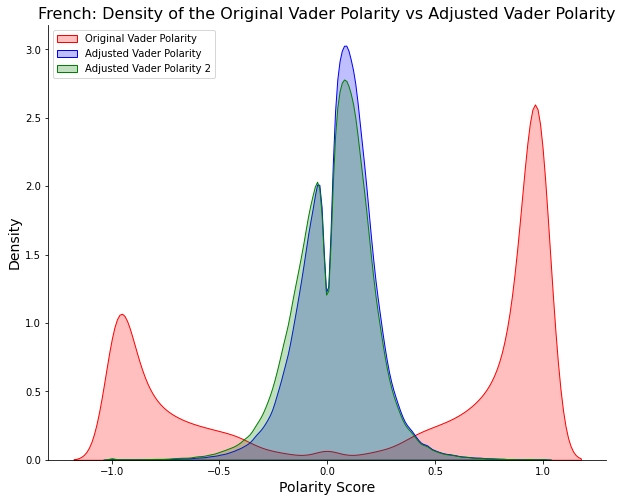

In [12]:
# Compare the density plots of the original and adjusted Vader polarity scores
fig = plt.figure(figsize = (10,8))
ax = sns.kdeplot(Vader_tx_polarity.Vader_polarity.values, shade = True, color = 'red', label = "Original Vader Polarity")
ax = sns.kdeplot(Vader_tx_polarity.Vader_polarity_adj.values, shade = True, color = 'blue', label = "Adjusted Vader Polarity")
ax = sns.kdeplot(Vader_tx_polarity.Vader_polarity_adj_2.values, shade = True, color = 'green', label = "Adjusted Vader Polarity 2")
ax.set_title("French: Density of the Original Vader Polarity vs Adjusted Vader Polarity")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

In [13]:
# Save the results to a csv file
Vader_tx_polarity.to_csv("Sentiment/Vader/VADER-fr/fr_vader_polarity_combined.csv", index = True)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
X. Inspection of two articles with similar original vader polarity but different length
</h2>
</div>

In [14]:
# Short with -0.7772 to -0.1196
fr_tx[1]

" Le fabricant de spécialités chimiques Sika s'attend à une embellie au deuxième semestre malgré la crise pandémique qui continue de créer l'incertitude sur les marchés. Paul Schuler, directeur général du groupe, a confirmé la feuille de route du groupe à l'horizon 2023. Sika n'a pas été déstabilisé par la crise du Covid 19. Le patron de ce groupe zougois actif dans la construction et l'industrie a confirmé la progression du groupe en pleine crise pandémique lors de la Journée des Investisseurs à Zurich. (awp)"

In [15]:
# Long with 0.7561 to 0.0414
fr_tx[2]

" Le SMI a perdu 0,41 à 10. 187,090 points, plus bas à 10. 169,78 et plus haut à 10. 266,97. Le SLI a cédé 0,08 à 1553,69 points et le SPI 0,27 à 12. 724,65 points. Après avoir fait une pointe durant la première heure de transactions, le SMI est reparti dans le rouge où il a évolué en dents de scie autour de la barre des 10. 200 points jusqu'en début d'après midi. Sur les 30 valeurs vedettes, 16 ont reculé et 14 avancé. Le podium du jour se compose de la volatile AMS (+3,1 ), Straumann (+2,7 ) et Julius Bär (+2,5 ). Les deux autres bancaires Credit Suisse (+1,9 ) et UBS (+1,7 ) suivent leur petite soeur de près. Sika (+0,9 ) s'attend à une embellie au deuxième semestre malgré la crise sanitaire qui continue de créer l'incertitude sur les marchés. Paul Schuler, CEO du groupe, a confirmé la feuille de route du groupe à l'horizon 2023. Givaudan (+0,2 ) a profité d'un relèvement de recommandation à buy de hold par Berenberg (lire ci dessous). Dans le camp des perdants, Roche ( 1,6 ) a fini